In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [8]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-06-19 02:52:48--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.007s  

2021-06-19 02:52:48 (9.70 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



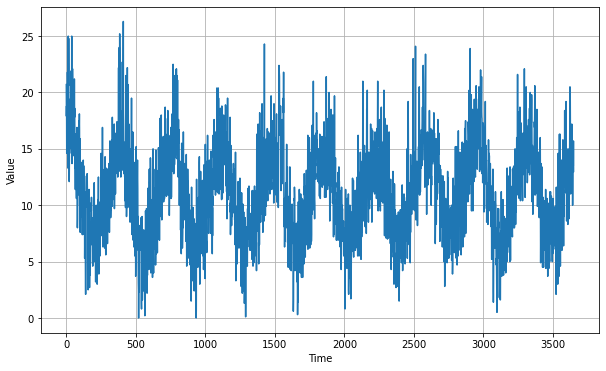

In [3]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [13]:
split_time = 2500
time_train = np.array(time_step[:split_time])
x_train = np.array(temps[:split_time])
time_valid = np.array(time_step[split_time:])
x_valid = np.array(temps[split_time:])

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [68]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)


model = tf.keras.models.Sequential([
# YOUR CODE HERE
  tf.keras.layers.Conv1D(64, 5, activation="relu"),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*25)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/150


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


10/10 [==============================] - 6s 27ms/step - loss: 2.7396 - mae: 3.2062
Epoch 2/150
10/10 [==============================] - 0s 31ms/step - loss: 2.7337 - mae: 3.2002
Epoch 3/150
10/10 [==============================] - 0s 30ms/step - loss: 2.7247 - mae: 3.1910
Epoch 4/150
10/10 [==============================] - 0s 28ms/step - loss: 2.7138 - mae: 3.1800
Epoch 5/150
10/10 [==============================] - 0s 29ms/step - loss: 2.7017 - mae: 3.1676
Epoch 6/150
10/10 [==============================] - 0s 29ms/step - loss: 2.6881 - mae: 3.1538
Epoch 7/150
10/10 [==============================] - 0s 30ms/step - loss: 2.6732 - mae: 3.1387
Epoch 8/150
10/10 [==============================] - 0s 32ms/step - loss: 2.6569 - mae: 3.1221
Epoch 9/150
10/10 [==============================] - 0s 31ms/step - loss: 2.6391 - mae: 3.1040
Epoch 10/150
10/10 [==============================] - 0s 30ms/step - loss: 2.6200 - mae: 3.0846
Epoch 11/150
10/10 [==============================] - 0s 32ms

(1e-08, 0.1, 0.0, 60.0)

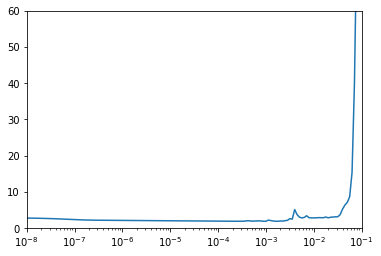

In [26]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 60])

In [61]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

'''
Optimal model:
*some amount of conv1d, possibly maxpooling2d*
*nested Bidirectional+Gru/LSTM*(actually no need foro bidirectional ig)
*nested dense layers*
*lambda to prevent high weights*
'''

model = tf.keras.models.Sequential([
# YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                    strides=1, padding="causal",
                    activation="relu",
                    input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  #may have to remove
  tf.keras.layers.Lambda(lambda x: x*25)
])



optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
optimizer="adam"
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=35)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/35
25/25 [==============================] - 53s 21ms/step - loss: 3.1623 - mae: 3.6174
Epoch 2/35
25/25 [==============================] - 1s 21ms/step - loss: 1.0460 - mae: 1.4709
Epoch 3/35
25/25 [==============================] - 1s 20ms/step - loss: 0.8109 - mae: 1.2213
Epoch 4/35
25/25 [==============================] - 1s 21ms/step - loss: 0.6375 - mae: 1.0378
Epoch 5/35
25/25 [==============================] - 1s 21ms/step - loss: 0.2966 - mae: 0.6339
Epoch 6/35
25/25 [==============================] - 1s 21ms/step - loss: 0.1068 - mae: 0.3307
Epoch 7/35
25/25 [==============================] - 1s 20ms/step - loss: 0.0861 - mae: 0.2984
Epoch 8/35
25/25 [==============================] - 1s 21ms/step - loss: 0.1234 - mae: 0.3874
Epoch 9/35
25/25 [==============================] - 1s 21ms/step - loss: 0.0523 - mae: 0.2028
Epoch 10/35
25/25 [==============================] - 1s 21ms/step - loss: 0.0797 - mae: 0.2837
Epoch 11/35
25/25 [==============================] - 1s 21

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          384       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 30)                3870      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [70]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

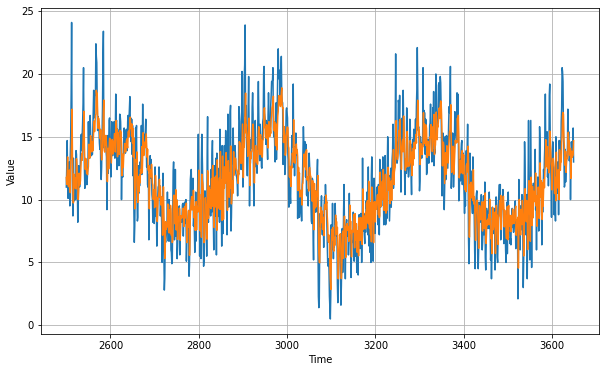

In [72]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [74]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7809403

In [75]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.75298  11.201638 12.437923 ... 13.488287 13.541211 14.684597]
